In [1]:
## Miscelaneous
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm
import pickle as pkl

import pybedtools
from pybedtools import BedTool

import subprocess

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel
from chromograph.pipeline import config
from chromograph.preprocessing.doublet_finder import doublet_finder

import cytograph as cg
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species

import glob

import fisher

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as stats
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

config = config.load_config()

from chromograph.pipeline.TF_IDF import TF_IDF


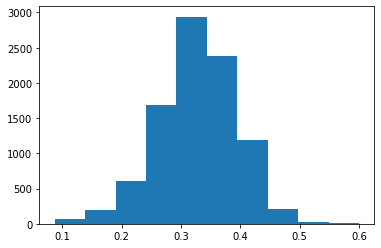

In [179]:
f = '/datb/sl/camiel/scATAC/samples_old/10X232_1/10X232_1_5kb.loom'

with loompy.connect(f) as ds:    
    plt.hist(ds.ca.promoter_region_fragments/ds.ca.passed_filters)

In [2]:
import logging
import os
import re
from typing import List

import numpy as np
import yaml

import loompy


class Annotation:
    unknown_tags: set = set()

    def __init__(self, category: str, filename: str) -> None:
        with open(filename) as f:
            doc = next(yaml.load_all(f, Loader=yaml.SafeLoader))

        if "name" in doc:
            self.name = doc["name"]
        else:
            raise ValueError(os.path.basename(filename) + " did not contain a 'name' attribute, which is required.")

        if "abbreviation" in doc:
            self.abbreviation = doc["abbreviation"]
        else:
            raise ValueError(os.path.basename(filename) + " did not contain an 'abbreviation' attribute, which is required.")

        if "definition" in doc:
            self.definition = doc["definition"]
            genes = self.definition.strip().split()
            self.positives = [x[1:] for x in genes if x.startswith("+")]
            self.negatives = [x[1:] for x in genes if x.startswith("-")]
        else:
            raise ValueError(os.path.basename(filename) + " did not contain a 'definition' attribute, which is required.")

        if "categories" in doc and doc["categories"] is not None:
            self.categories = re.split(r"\W+", doc["categories"].strip())
        else:
            self.categories = []

    def __str__(self) -> str:
        temp = self.name + " (" + self.abbreviation + "; " + " ".join(["+" + x for x in self.positives])
        if len(self.negatives) > 0:
            temp = temp + " " + " ".join(["-" + x for x in self.negatives]) + ")"
        else:
            temp = temp + ")"
        return temp


class AutoAnnotator_tmp(object):
    def __init__(self, root: str, ds: loompy.LoomConnection = None) -> None:
        self.root = root
        self.definitions: List[Annotation] = []
        self.genes: List[str] = [] if ds is None else ds.ra.Gene
        self.accessions: List[str] = [] if ds is None else ds.ra.Accession
        self.annotations = None  # type: np.ndarray

        fileext = [".yaml", ".md"]
        root_len = len(self.root)
        for cur, _, files in os.walk(self.root):
            for file in files:
                errors = False
                if os.path.splitext(file)[-1] in fileext and file[-9:] != "README.md":
                    try:
                        tag = Annotation(cur[root_len:], os.path.join(cur, file))
                        for pos in tag.positives:
                            if len(self.genes) > 0 and (pos not in self.genes and pos not in self.accessions):
                                logging.error(file + ": gene '%s' not found in file", pos)
                                errors = True
                        for neg in tag.negatives:
                            if len(self.genes) > 0 and (neg not in self.genes and neg not in self.accessions):
                                logging.error(file + ": gene '%s' not found in file", neg)
                                errors = True
                        if not errors:
                            self.definitions.append(tag)
                    except Exception as e:
                        logging.error(file + ": " + str(e))
                        errors = True
        # if errors:
        # 	raise ValueError("Error loading cell tag definitions")

    def fit(self, ds: loompy.LoomConnection, threshold: float = 0.5, layer: str = 'trinaries') -> np.ndarray:
        """
        Return the annotation for an already aggregated and trinarized loom file
        The input file should have one column per cluster and a layer named "binary"
        Returns:
            An array of strings giving the auto-annotation for each cluster
        """
        self.genes = ds.ra.Gene
        self.accessions = ds.ra.Accession
        X = ds.layers[layer]
        self.annotations = np.empty((len(self.definitions), X.shape[1]))
        for ix, tag in enumerate(self.definitions):
#             n_markers = len(tag.positives) + len(tag.negatives)
            n_markers = len(tag.positives)            
            for cluster in range(X.shape[1]):
#                 p = 1
                p = 0
                for pos in tag.positives:
                    if pos not in self.genes and pos not in self.accessions:
                        logging.error(f"Auto-annotation gene {pos} (used for {tag}) not found in file")
                        continue
                    if pos in self.genes:
                        index = np.where(self.genes == pos)[0][0]
                    else:
                        index = np.where(self.accessions == pos)[0][0]
                    p = p + X[index, cluster]
#                     p = p * X[index, cluster]
                for neg in tag.negatives:
                    if neg not in self.genes and neg not in self.accessions:
                        logging.error(f"Auto-annotation gene {neg} (used for {tag}) not found in file")
                        continue
                    if neg in self.genes:
                        index = np.where(self.genes == neg)[0][0]
                    else:
                        index = np.where(self.accessions == neg)[0][0]
#                     p = p + (1 - X[index, cluster])
                    p = p * (1 - X[index, cluster])
                p = p / n_markers
                self.annotations[ix, cluster] = p

        attr = []
        for ix in range(self.annotations.shape[1]):
            tags = []  # type: List[str]
            for j in range(self.annotations.shape[0]):
                if self.annotations[j, ix] >= threshold:
                    tags.append(self.definitions[j].abbreviation)
            tags.sort()
            attr.append(" ".join(tags))

        return np.array(attr)

    def annotate(self, ds: loompy.LoomConnection) -> None:
        """
        Annotate an aggregated and trinarized loom file
        Remarks:
            Creates the following new column attributes:
                AutoAnnotation:		Space-separated list of auto-annotation labels

        The input file should have one column per cluster and a layer named "binary"
        """
        ds.ca.AutoAnnotation = self.fit(ds)

In [114]:
from chromograph.peak_analysis.utils import KneeBinarization
f_agg = '/proj/DEV_ATAC/Build_20210312/All/All_prom.agg.loom'
f = '/proj/DEV_ATAC/Build_20210312/All/All_prom.loom'

with loompy.connect(f_agg) as ds:
    ds['binary'], ds.ca.CPM_threshold = KneeBinarization(ds, mode='linear')

12:09:01 INFO     Binarize clusters by knee point
100%|██████████| 217/217 [00:12<00:00, 17.56it/s]


In [126]:
from cytograph.enrichment import Trinarizer

with loompy.connect(f_agg) as dsout:
    with loompy.connect(f) as ds:
        dsout['trinaries'] = Trinarizer(0.2).fit(ds)

13:41:33 INFO     n_labels 217


In [151]:
abb = 'M-MGL'
genes = [x.positives for x in Annotator.definitions if x.abbreviation == abb]
with loompy.connect(f_agg) as ds:
    for g in genes[0]:
        print(f"{g}: {np.sum(ds['binary'][ds.ra.Gene == g,:].flatten())}")

AIF1: 0.0
HEXB: 54.0


433
4763


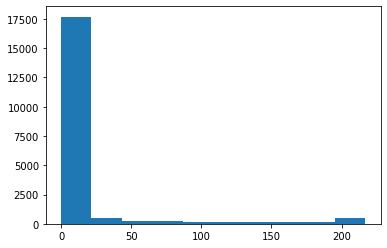

In [111]:
with loompy.connect(f_agg) as ds:
    X = ds['binary'].map([np.sum],axis=0)[0]

    plt.hist(X)
    print(np.sum(X>200))
    print(np.sum((X<200)&(X>0)))

In [150]:
with loompy.connect(f_agg) as ds:
    Annotator = AutoAnnotator(root='/home/camiel/auto-annotation/Human/', ds=ds)
    X = Annotator.fit(ds, threshold=.25, layer='binary')
X

array(['NT-GABA NT-GLY', 'NT-GABA NT-GLY', 'NT-GABA NT-GLY',
       'NT-GABA NT-GLY', 'NT-GABA NT-GLY', 'NT-GABA NT-GLY',
       'NT-GABA NT-GLY', 'NT-GABA NT-GLY', '', 'NT-GABA NT-GLY', '',
       'NT-GABA NT-GLY TH-RETN', 'NT-GABA NT-GLY TH-RETN',
       'NT-GABA NT-GLY', 'NT-GABA NT-GLY TH-RETN',
       'NT-GABA NT-GLY TH-RETN', 'NT-GABA NT-GLY TH-RETN',
       'NT-GABA NT-GLY', 'NT-GABA NT-GLY TH-RETN', '', 'RGL TH-RETN', '',
       '', 'O-COP', 'M-MGL NT-GABA NT-GLY TH-RETN',
       'NT-GABA NT-GLY TH-RETN', 'M-MGL', '', '', '', '', '', '', '', '',
       '', 'NT-GABA NT-GLY', '', 'NT-GABA NT-GLY', 'NT-GABA NT-GLY',
       'M-MGL NT-GABA NT-GLY', '', '', 'NBL', 'TH-RETN', 'NT-GABA NT-GLY',
       '', '', 'NT-GABA NT-GLY TH-RETN', 'NT-GABA NT-GLY TH-RETN',
       'NT-GABA NT-GLY P-DLGE P-MGE-PO P-VLGE TH-RETN',
       'NT-GABA NT-GLY P-DLGE P-MGE-PO P-VLGE', '', 'NBL', 'TH-RETN',
       'TH-RETN', 'TH-RETN', '', 'M-MGL NBL TH-RETN', 'NBL TH-RETN',
       'P-PALL-M TH-RETN', 'NBL NT

(array([9.521e+03, 0.000e+00, 2.200e+01, 1.120e+02, 3.300e+01, 2.000e+02,
        5.000e+00, 0.000e+00, 1.000e+01, 7.900e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

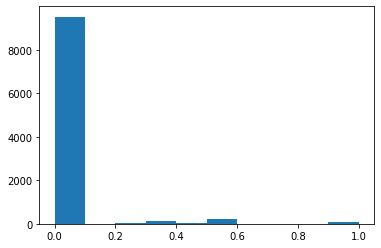

In [147]:
plt.hist(Annotator.annotations.flatten())

In [141]:
X[208:211]

array(['M-MGL P-HYP RGL TH-RETN', 'M-MGL TH-RETN', 'M-MGL RGL TH-RETN'],
      dtype='<U45')

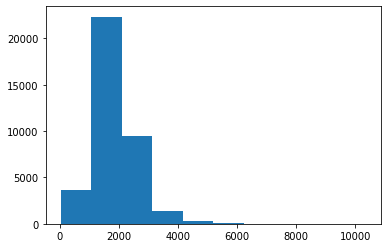

In [34]:
f = '/proj/DEV_ATAC/Build_RNA_20210325/data/All.loom'

with loompy.connect(f) as ds:
    plt.hist(ds.ca.NGenes)

In [18]:
for x in Annotator.definitions:
    tests = len(x.positives) + len(x.negatives)
    print(x.abbreviation, tests, len(x.positives), len(x.negatives), x.negatives)

CB-PURK 2 2 0 []
E-SCHWL 1 1 0 []
HB-OTV 2 2 0 []
NBL 1 1 0 []
NEUR 1 1 0 []
RGL 5 5 0 []
TH-RETN 3 3 0 []
M-CHRP 2 2 0 []
M-ENDO 3 3 0 []
M-ERY 1 1 0 []
M-MGL 2 2 0 []
M-PER 1 1 0 []
M-PER 1 1 0 []
M-PVM 2 2 0 []
M-VLMC 2 2 0 []
NP-AGRP 1 1 0 []
NP-AVP 1 1 0 []
NP-GNRH 1 1 0 []
NP-HCRT 1 1 0 []
NP-OXT 1 1 0 []
NP-PMCH 1 1 0 []
NP-POMC 1 1 0 []
NP-TRH 1 1 0 []
NT-ADR 4 4 0 []
NT-CHOL 2 2 0 []
NT-DA 3 3 0 []
NT-GABA 3 2 1 ['SLC6A5']
NT-GLY 2 2 0 []
NT-NOR 3 3 0 []
NT-SER 2 2 0 []
NT-VGLUT1 1 1 0 []
NT-VGLUT2 1 1 0 []
NT-VGLUT3 1 1 0 []
O-COP 3 3 0 []
O-HEM 2 2 0 []
P-DLGE 2 2 0 []
P-FP1 1 1 0 []
P-FPL 1 1 0 []
P-HYP 2 2 0 []
P-MGE-PO 2 2 0 []
P-PALL-M 2 2 0 []
P-PALL 1 1 0 []
P-VLGE 3 1 2 ['PAX6', 'NKX2-1']
S-CC 1 1 0 []
S-G1S 2 2 0 []
S-G2M 2 2 0 []


## INFERRED RNA

In [119]:
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import Trinarizer
from collections import Counter
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist
min_cells = 10

test_dir = '/proj/DEV_ATAC/test/'
f = os.path.join(test_dir, 'All_rna.loom')
f_agg = os.path.join(test_dir, 'All_rna.agg.loom')

agg_spec = {
    "Age": "mean",
    "Clusters": "first",
    "Class": "mode",
    "Total": "mean",
    "Sex": "tally",
    "Tissue": "tally",
    "Chemistry": "tally",
    "SampleID": "tally",
    "TissuePool": "first",
    "Outliers": "mean",
    "PCW": "mean"
}

with loompy.connect(f) as ds:

    cells = ds.col_attrs["Clusters"] >= 0
    labels = ds.col_attrs["Clusters"][cells]
    n_labels = len(set(labels))
    
    if not os.path.isfile(f_agg):
        logging.info(f'Aggregating file')
        ds.aggregate(f_agg, None, "Clusters", "mean", agg_spec)
        
        with loompy.connect(f_agg) as dsout:
            dsout.ca.NCells = np.bincount(labels, minlength=n_labels)[dsout.ca.Clusters]

            dsout.ca.Clusters_peaks = dsout.ca.Clusters
            dsout.ca.Clusters = np.arange(n_labels)
            if not np.max(ds.ca.Clusters) == n_labels - 1:
                d = {k:v for k, v in zip(dsout.ca.Clusters_peaks, dsout.ca.Clusters)}
                ds.ca.Clusters_peaks = ds.ca.Clusters
                ds.ca.Clusters = [d[x] for x in ds.ca.Clusters]
        
    with loompy.connect(f_agg) as dsout:

        if not 'MarkerGenes' in dsout.ca:
            logging.info("Computing cluster gene enrichment scores")
            fe = FeatureSelectionByMultilevelEnrichment(mask=Species.detect(ds).mask(dsout, ("cellcycle", "sex", "ieg", "mt")))
            markers = fe.fit(ds)
            dsout.layers["enrichment"] = fe.enrichment

            # Renumber the clusters
            logging.info("Renumbering clusters by similarity, and permuting columns")

            data = np.log(dsout[:, :] + 1)[markers, :].T
            D = pdist(data, 'correlation')
            Z = hc.linkage(D, 'ward', optimal_ordering=True)
            ordering = hc.leaves_list(Z)

            # Permute the aggregated file, and renumber
            dsout.permute(ordering, axis=1)
            dsout.ca.Clusters = np.arange(n_labels)

            # Redo the Ward's linkage just to get a tree that corresponds with the new ordering
            data = np.log(dsout[:, :] + 1)[markers, :].T
            D = pdist(data, 'correlation')
            dsout.attrs.linkage = hc.linkage(D, 'ward', optimal_ordering=True)

            # Renumber the original file, and permute
            d = dict(zip(ordering, np.arange(n_labels)))
            new_clusters = np.array([d[x] if x in d else -1 for x in ds.ca.Clusters])
            ds.ca.Clusters = new_clusters
            ds.permute(np.argsort(ds.col_attrs["Clusters"]), axis=1)

            # Reorder the genes, markers first, ordered by enrichment in clusters
            logging.info("Permuting rows")
            mask = np.zeros(ds.shape[0], dtype=bool)
            mask[markers] = True
            # fetch enrichment from the aggregated file, so we get it already permuted on the column axis
            gene_order = np.zeros(ds.shape[0], dtype='int')
            gene_order[mask] = np.argmax(dsout.layer["enrichment"][mask, :], axis=1)
            gene_order[~mask] = np.argmax(dsout.layer["enrichment"][~mask, :], axis=1) + dsout.shape[1]
            gene_order = np.argsort(gene_order)
            ds.permute(gene_order, axis=0)
            dsout.permute(gene_order, axis=0)
        
        if 'trinaries' not in dsout.layers:
            logging.info(f'Trinarizing')
            trinaries = Trinarizer(0.2).fit(ds)
            dsout['trinaries'] = trinaries[:,dsout.ca.Clusters]
        
        logging.info(f'Annotating')
        AutoAnnotator(root='/home/camiel/auto-annotation/Human/', ds=dsout).fit(dsout)
        
        logging.info("Computing auto-auto-annotation")
        AutoAutoAnnotator(n_genes=6).annotate(dsout)        
    
        ## Remove undersampled clusters
        remove = dsout.ca.Clusters[dsout.ca.NCells < min_cells]
        for id in remove:
            for k in ['AutoAnnotation', 'MarkerGenes', 'MarkerRobustness', 'MarkerSelectivity', 'MarkerSpecificity']:
                dsout.ca[k][dsout.ca.Clusters == id] = ''
        
        ## Restore clusterlabels
        for dsx in [ds,dsout]:
            dsx.ca.Clusters_renumbered = dsx.ca.Clusters
            dsx.ca.Clusters = dsx.ca.Clusters_peaks

f_prom_agg = '/proj/DEV_ATAC/test/All_prom_agg.loom'
with loompy.connect(f_agg) as dsagg:
    with loompy.connect(f_prom_agg) as dsout:
        annot = np.repeat('', dsout.shape[1]).astype('U128')
        annot[dsagg.ca.Clusters] = dsagg.ca.AutoAnnotation
        dsout.ca.AutoAnnotation = annot
        
        annot = np.repeat('', dsout.shape[1]).astype('U128')
        annot[dsagg.ca.Clusters] = dsagg.ca.MarkerGenes
        dsout.ca.MarkerGenes = annot    

17:26:47 INFO     Annotating
17:27:45 INFO     Computing auto-auto-annotation


In [133]:
import cytograph.plotting as cgplot

f_plot = '/proj/DEV_ATAC/test/All_rna2.loom'
f_prom_agg = '/proj/DEV_ATAC/test/All_prom_agg.loom'

with loompy.connect(f_plot) as ds:
    with loompy.connect(f_prom_agg) as dsagg:
        cgplot.manifold(ds, '/proj/DEV_ATAC/test/Annotations.png', list(dsagg.ca.MarkerGenes), list(dsagg.ca.AutoAnnotation), embedding = 'TSNE')

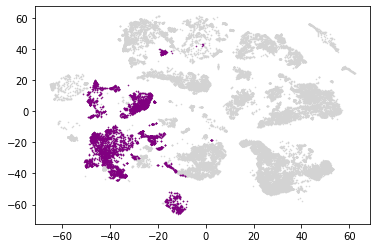

In [134]:
emb = 'TSNE'
annot = 'RGL'

with loompy.connect(f) as ds:
    with loompy.connect(f_prom_agg) as dsagg:
        clusters = set(dsagg.ca.Clusters[[annot in dsagg.ca.AutoAnnotation[ix].split(" ") for ix in range(dsagg.shape[1])]])
        valid = [x in clusters for x in ds.ca.Clusters]
        plt.scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], marker='.', s=1, c='lightgray')
        plt.scatter(ds.ca[emb][valid,0], ds.ca[emb][valid,1], marker='.', s=1, c='purple')        

In [ ]:
f_agg = os.path.join(test_dir, 'All_rna.agg.loom')
f_agg_rna = '/proj/DEV_ATAC/Build_RNA_20210325/data/All.agg.loom'

gene = 'SOX10'
with loompy.connect(f_agg) as ds:
    plt.hist(ds['trinaries_0_05'][ds.ra.Gene == gene,:].flatten(), alpha=.5)
    plt.hist(ds['trinaries_0_1'][ds.ra.Gene == gene,:].flatten(), alpha=.5)
    plt.figure()
    plt.hist(ds['trinaries'][ds.ra.Gene == gene,:].flatten(), alpha=.5)
    
with loompy.connect(f_agg_rna) as ds:
    plt.figure()
    plt.hist(ds['trinaries'][ds.ra.Gene == gene,:].flatten(), alpha=.5)

In [7]:
abb = 'CB-PURK'
genes = [x.positives for x in Annotator.definitions if x.abbreviation == abb]
print([x.name for x in Annotator.definitions if x.abbreviation == abb])
with loompy.connect(f_agg) as ds:
    for g in genes[0]:
        print(f"{g}: {np.sum(ds['trinaries'][ds.ra.Gene == g,:].flatten() > 0.8)}")

['Purkinje cell']
PCP4: 24
RORA: 171


['Purkinje cell']


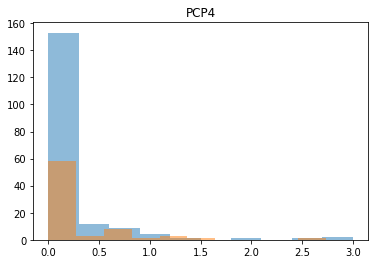

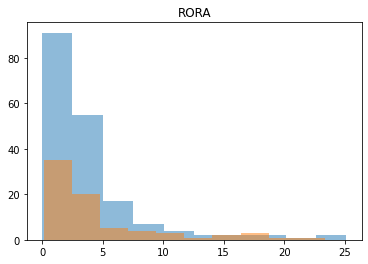

In [24]:
abb = 'CB-PURK'
genes = [x.positives for x in Annotator.definitions if x.abbreviation == abb]
print([x.name for x in Annotator.definitions if x.abbreviation == abb])

for g in genes[0]:
    plt.figure()
    plt.title(g)
    with loompy.connect(f_agg) as ds:
        plt.hist(ds[''][ds.ra.Gene == g,:].flatten(), alpha=.5)
        
    with loompy.connect(f_agg_rna) as ds:
        plt.hist(ds[''][ds.ra.Gene == g,:].flatten(), alpha=.5)

(32732, 29520)


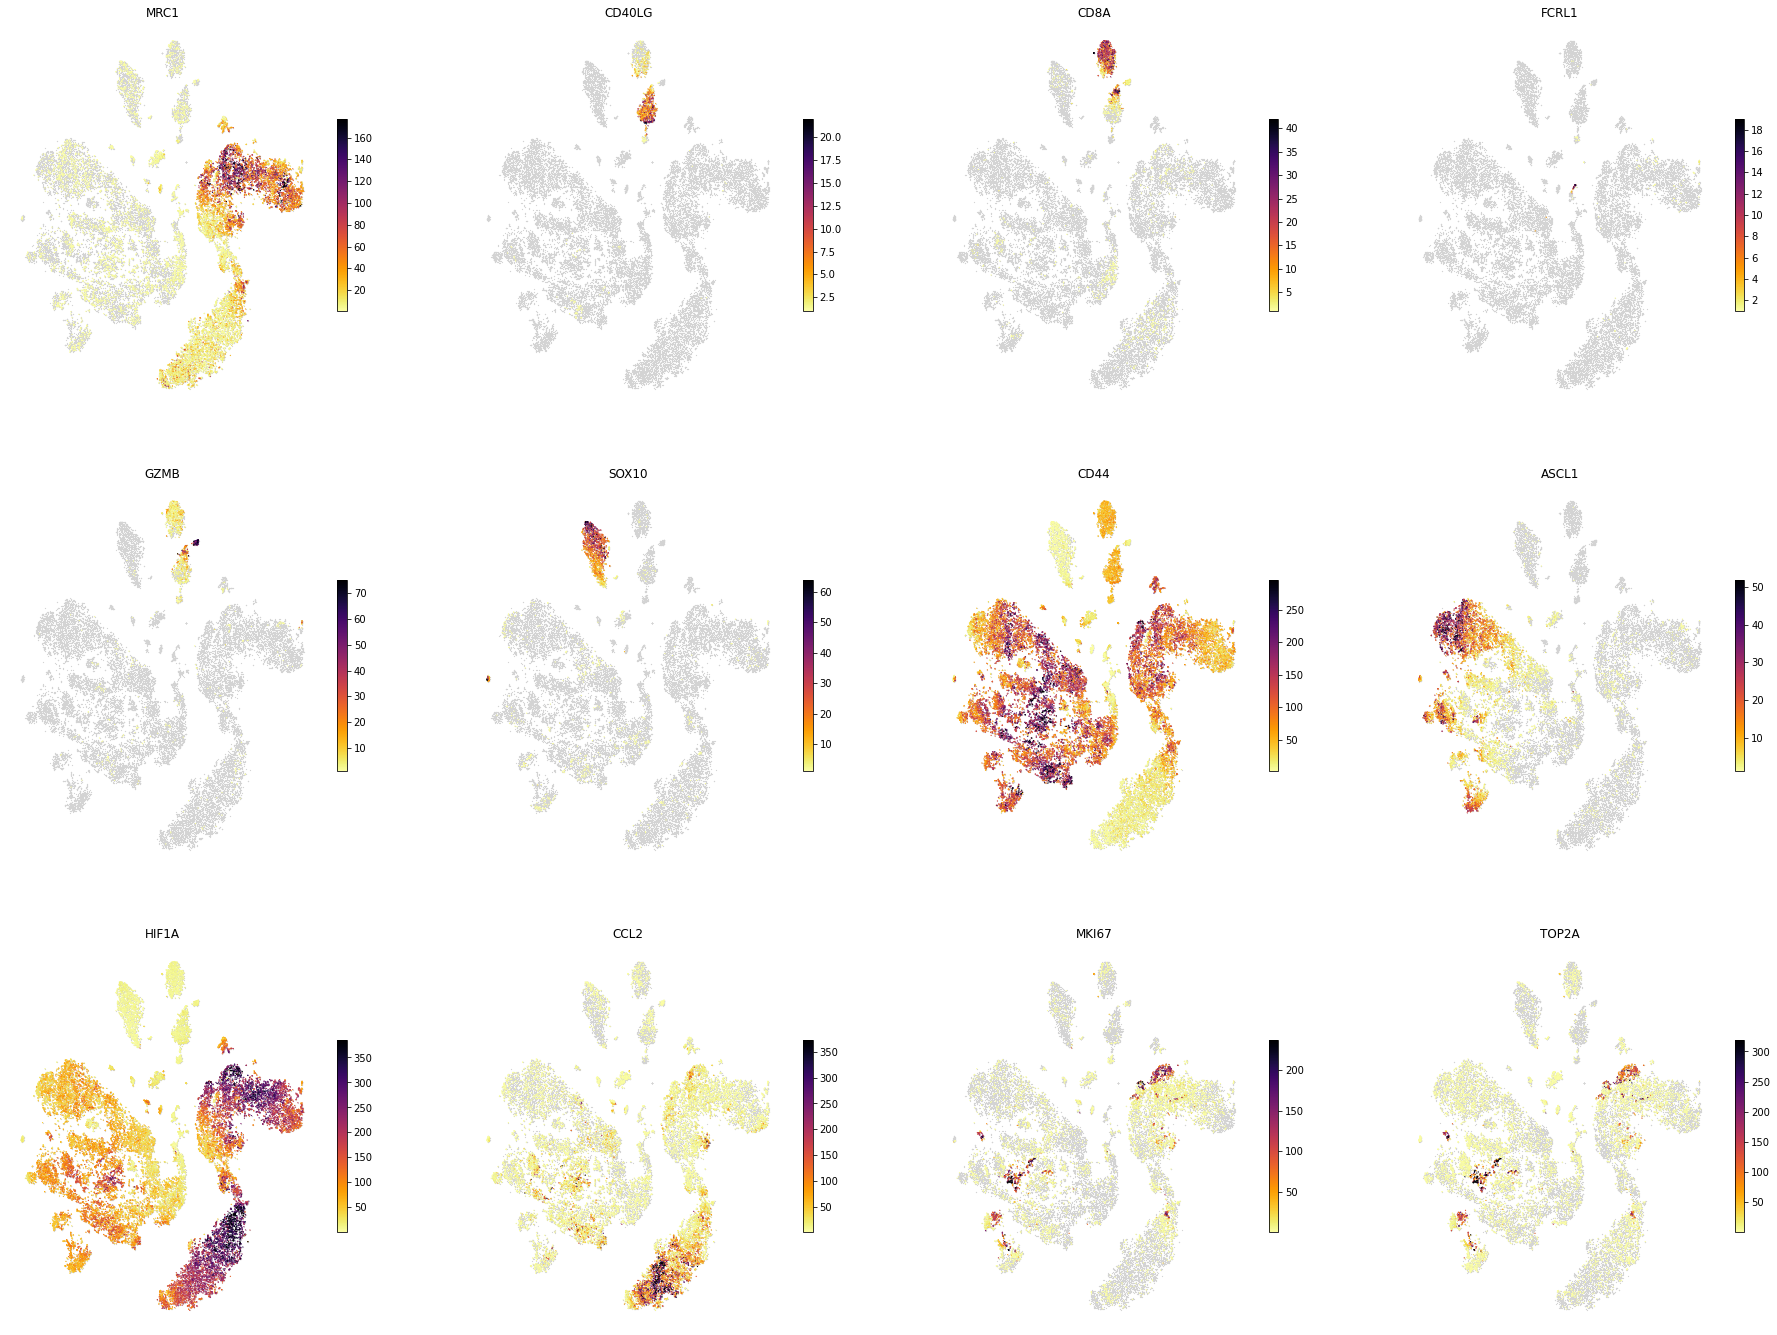

In [198]:
f = '/proj/DEV_ATAC/RNA/RNA_GBM_20210528/data/All.loom'
genes = ['MRC1', 'CD40LG', 'CD8A', 'FCRL1', 'GZMB', 'SOX10', 'CD44', 'ASCL1', 'HIF1A', 'CCL2', 'MKI67', 'TOP2A']

fig, ax = plt.subplots(3,4, figsize=(32,24))
ax = ax.flatten()

with loompy.connect(f, 'r') as ds:
    print(ds.shape)
    for i, gene in enumerate(genes):
        ## Inferred
        v = ds.layer['pooled'][ds.ra.Gene == gene,:].flatten()
        x = np.where(v > 0)[0]
        ax[i].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
        ax[i].set_title(gene)
        im = ax[i].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='inferno_r', vmax = np.quantile(v[x], .99), marker='.', lw=0, s=6)
        ax[i].axis('off')
        fig.colorbar(im, ax=ax[i], orientation='vertical', shrink=.5)
    plt.savefig('/home/camiel/misc/tumor_markers')

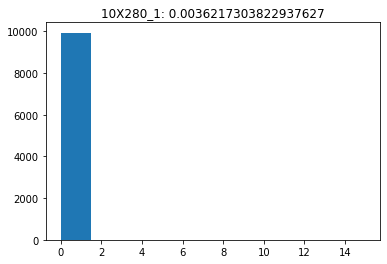

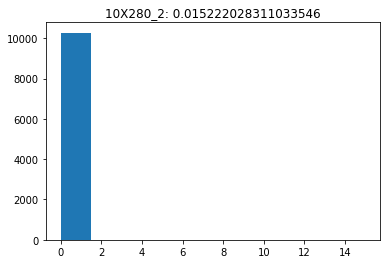

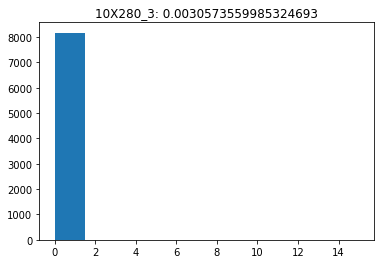

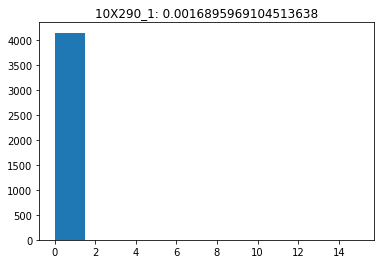

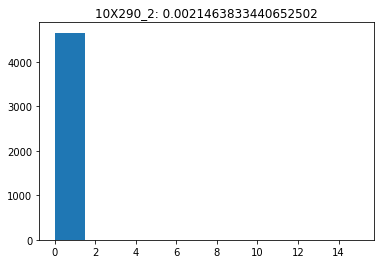

In [152]:
f = '/proj/DEV_ATAC/RNA_20210325/data/All.loom'

with loompy.connect(f, 'r') as ds:
    v = ds.layer[''][ds.ra.Gene == 'HBG1',:].flatten()
    
    for sample in np.unique(ds.ca.Name):
        x = ds.ca.Name == sample
            
        plt.figure()
        plt.title(f'{sample}: {np.sum(v[x]>0)/len(v[x])}')
        plt.hist(v[x], range=(0,15))

(33538, 37233)
(37233,)


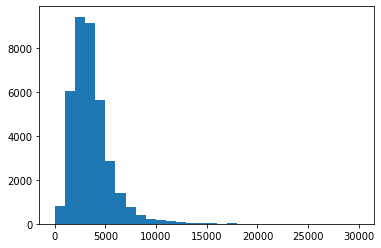

In [150]:
f = '/proj/DEV_ATAC/RNA_20210325/data/All.loom'
with loompy.connect(f, 'r') as ds:
    print(ds.shape)
    X = ds.map([np.sum], axis = 1)[0]
    print(X.shape)
    plt.hist(X, range=(0,30000), bins=30)

(36601, 10827)
(10827,)


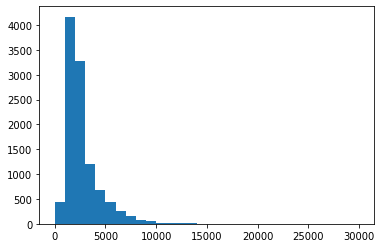

In [151]:
f = '/proj/loom/10X280_2.loom'
with loompy.connect(f, 'r') as ds:
    print(ds.shape)
    X = ds.map([np.sum], axis = 1)[0]
    print(X.shape)
    plt.hist(X, range=(0,30000), bins=30)

(36601, 10827)


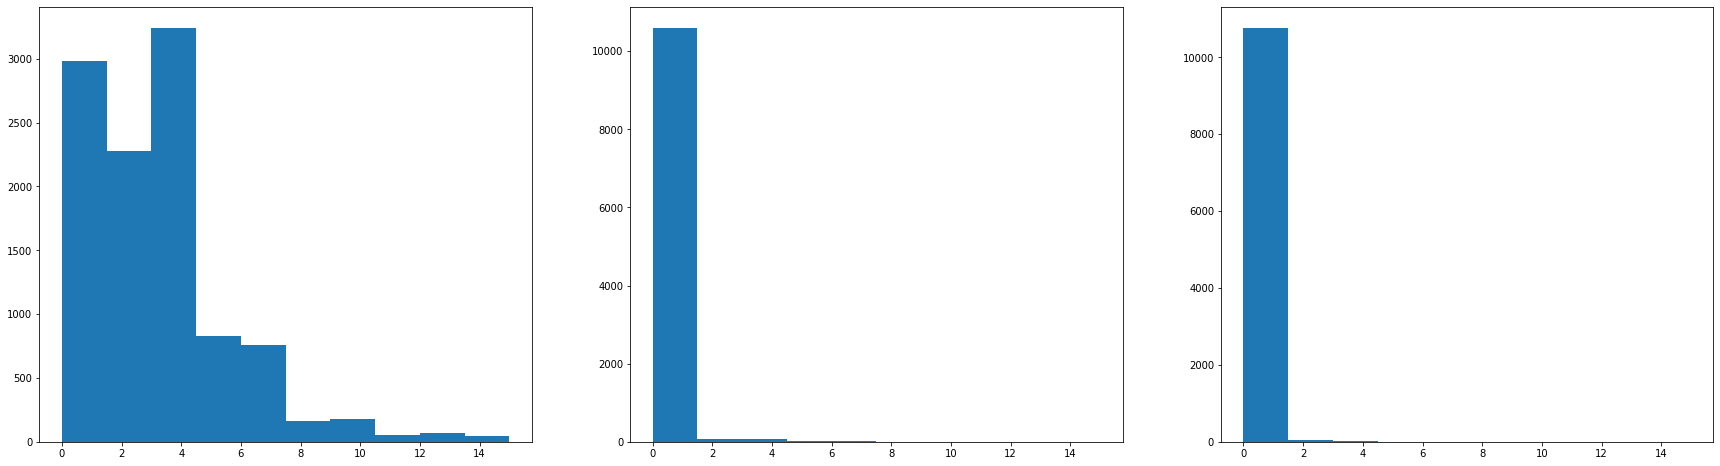

In [147]:
f = '/proj/loom/10X280_2.loom'
genes = ['HBG1', 'CLDN5', 'PCP4']
fig, ax = plt.subplots(1,3, figsize=(30,8))

with loompy.connect(f, 'r') as ds:
    print(ds.shape)
    for i, gene in enumerate(genes):
        ## Inferred
        v = ds.layer[''][ds.ra.Gene == gene,:].flatten()
        im = ax[i].hist(v, range=(0,15))
